In [2]:
# Adjust plot aspect ratio and apperance
library(repr)
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 400)

library("tidyverse")
library("moderndive")

suppressPackageStartupMessages({
  library("janitor")
  library("car")
  library("corrplot")
  library("ISLR")
  library("plotly")
  library("cowplot")
})

# Only display 10 rows of tibble
repr_html.tbl_df <- function(obj, ..., rows = 10) repr:::repr_html.data.frame(obj, ..., rows = rows)

# ggplot theme
theme <- list(
  theme_bw(),
  scale_color_brewer(palette = "Dark2"),
  theme(legend.position = "none")
)

# fit summary
fit_summary <- function(model) {
  tb <- broom::glance(model)[c("r.squared", "nobs", "statistic")]
  tb <- tb |>
    add_column(r = sqrt(tb$r.squared), .before = "r.squared") |>
    rename(`R^2` = r.squared, R = r)
  return(round(tb, 2))
}

# `Credit` dataset
data <- Credit |>
  as_tibble() |>
  clean_names() |>
  rename(debt = balance) |>
  mutate(income = income * 1000)

# Overwrite

regression_table <- function(model) {
  return(get_regression_table(model)[c("term", "estimate", "statistic")] |> rename(beta = estimate))
}

# Multicolinearity in Linear Regression

<img src="images/lines.jpg" width=50%>

<p style="text-align:left;">
    <a href="https://www.pexels.com/photo/marketing-businessman-person-hands-6801872/">Photo by Anna Nekrashevich from Pexels</a>
    <span style="float:right;">
        May 19, 2022 <br>
        Firas Moosvi
    </span>
</p>



## Learning Context (2 mins)

<img src="images/avatars.jpg" width=50% align="center">

### Academic program:

- Block 3 of the UBC Master of Data Science (MDS) program
- One of 4 concurrent courses students are taking
- ~ 120 students in the program
- Class 5 of 8

### Course Details

- DSCI 561 - Regression I
- **Prerequisite**:
    - DSCI 552 - Statistical Inference and Computation I
- Core course, required for several follow-up courses
- It's relatively early in the program, almost everyone in here wants to be here and is excited to learn more!

### Programming Experience

- Least experienced: Two blocks of working in Python and R sporadically
- Most experienced:  Worked in software industry for 2+ years

### Learning Intentions

- LI 1

- LI 2

- LI 3

- LI4

## Recap: `Credit` dataset and Multiple Linear Regression (5 mins)

### Reminder: `Credit` dataset

| Variable    | Range (Unit) | Description                      |
|-------------|--------------|----------------------------------|
| `debt`      | (\$)         | Average credit card debt         |
| `income`    | (\$)         | Total Income                     |
| `limit`     | (\$)         | Credit Limit                     |
| `rating`    | 0-1000       | Credit Rating                    |
| `cards`     | 2 - 9        | Number of Credit Cards           |
| `age`       | 23 - 98      | Age of individual                |
| `education` | 5 - 20       | Years of Education               |
| `gender`    | -            | Male/Female                      |
| `ethnicity` | -            | Caucasian/Asian/African American |
| `student`   | -            | Yes/No                           |
| `married`   | -            | Yes/No                           |

Reference: [An introduction to statistical learning with applications in R. by Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani.](https://www.statlearning.com)

### Linear Regression: credit `debt` regressed on credit `limit`

$\hat{debt} = \beta_0 + \beta_1\textrm{limit}$

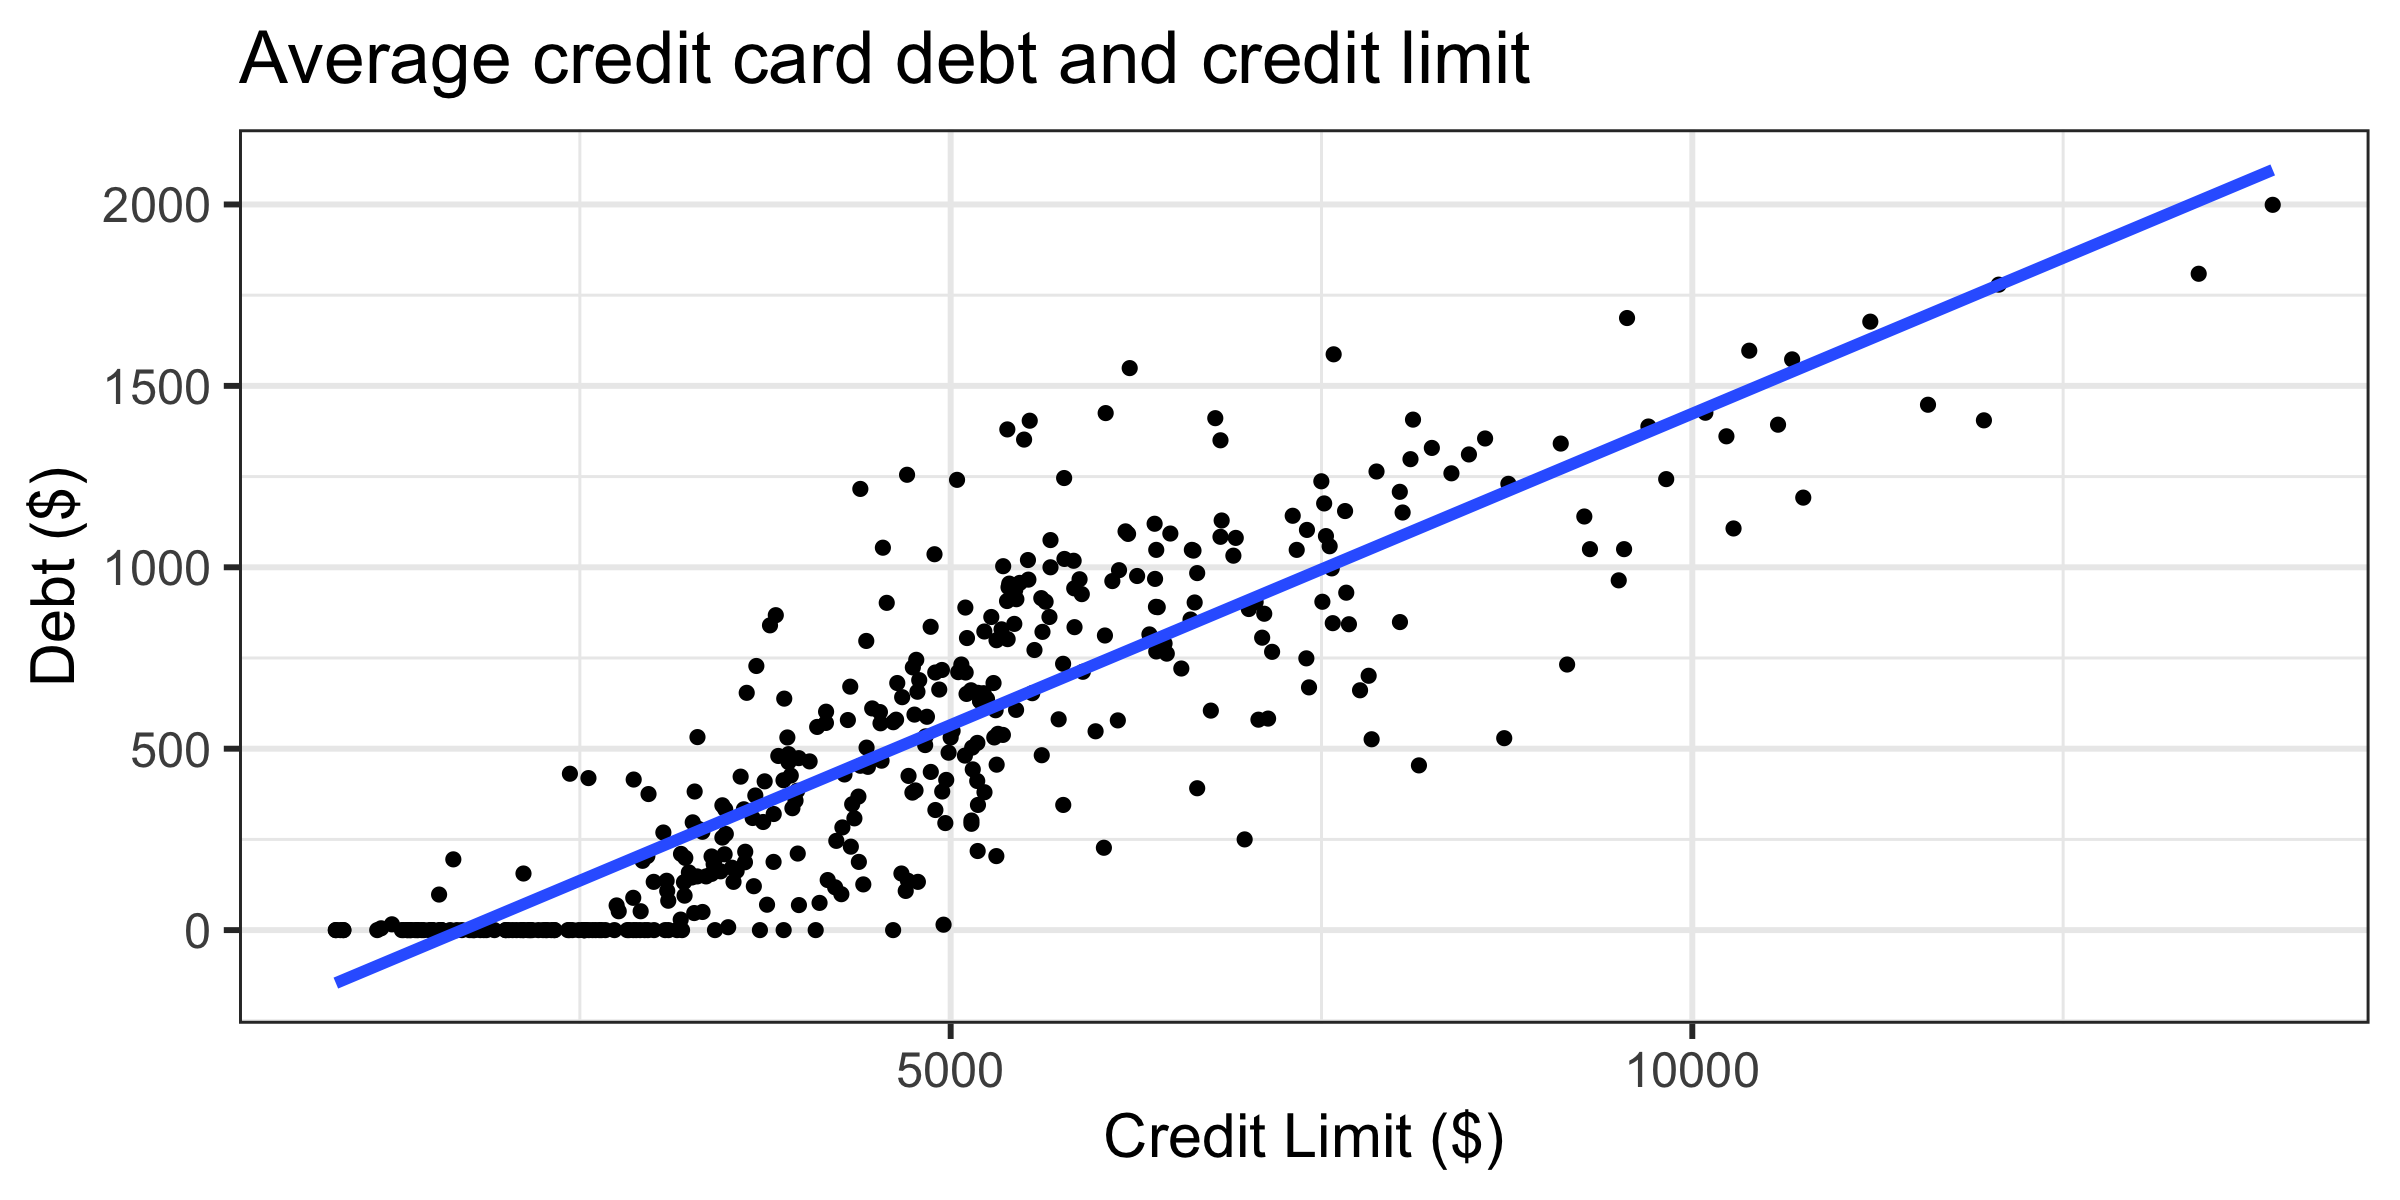

In [3]:
plot1 <- ggplot(data, aes(y = debt, x = limit)) +
  geom_point(size = 0.7) +
  theme_classic() +
  theme +
  labs(x = "Credit Limit ($)", y = "Debt ($)")

plot1 + geom_smooth(method = "lm", se = FALSE, formula = y ~ x) + labs(title = "Average credit card debt and credit limit")

In [4]:
model1 <- lm(debt ~ limit, data)
regression_table(model1)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-292.790,-10.973
limit,0.172,33.879


In [5]:
fit_summary(model1)

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.86,0.74,400,1147.76


#### Interpretation

$R = 0.86 $ - Strength of the linear relationship between two variables.

$R^2 = 0.74 $ -  The proportion of the variance in the response variable that can be explained by the explanatory variables in the regression model.

### Multiple Linear Regression: credit `debt` regressed on credit `limit` and credit `rating`

$\hat{debt} = \beta_0 + \beta_1\textrm{limit} + \beta_2\textrm{rating}$

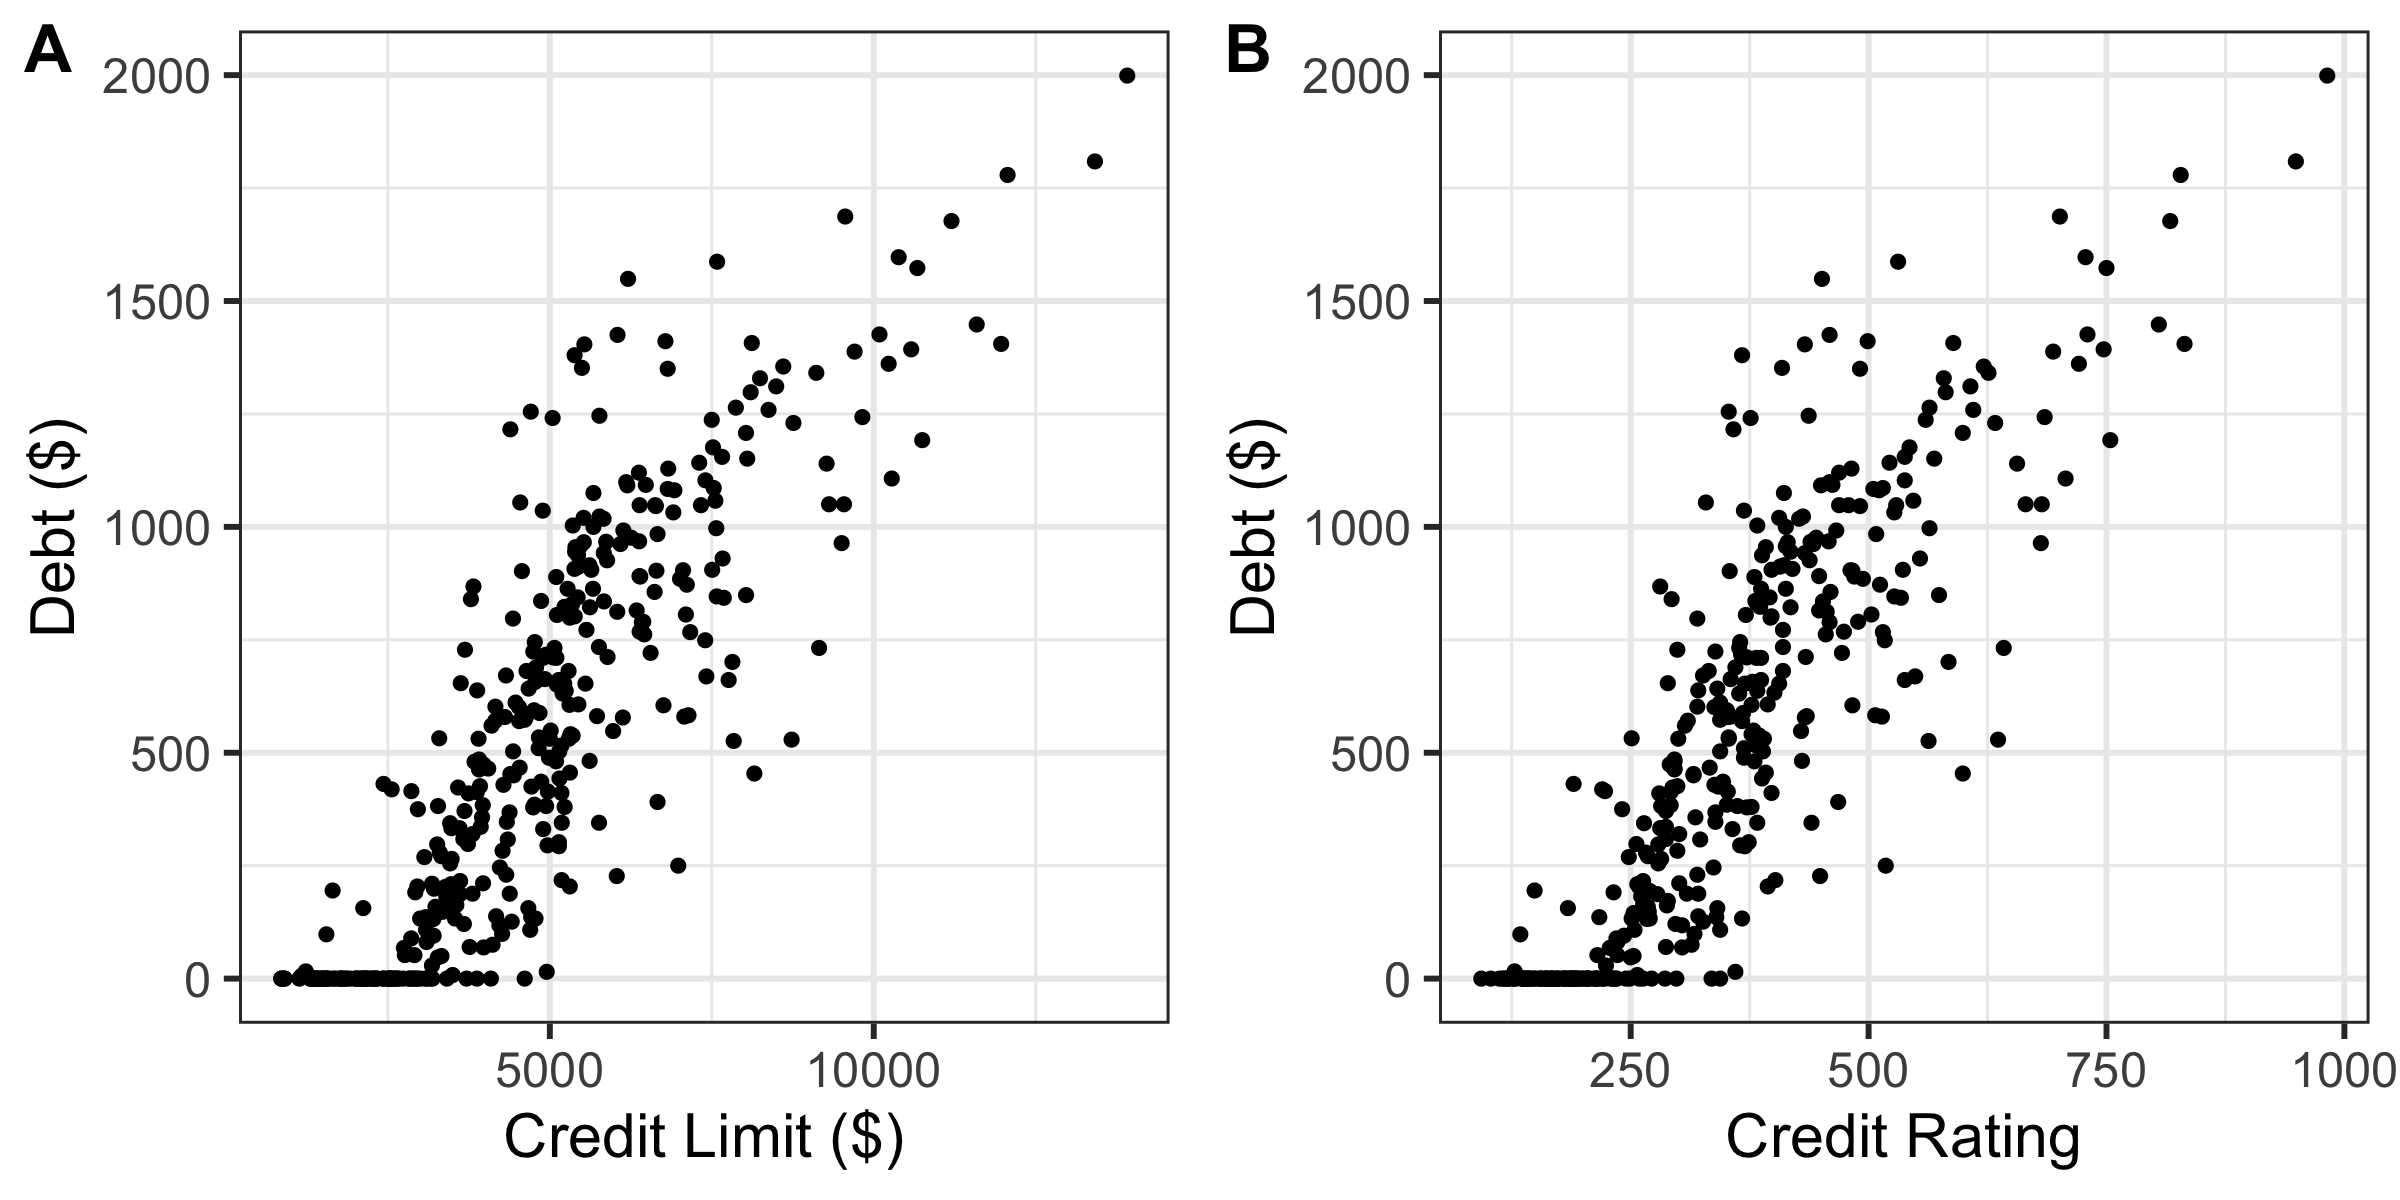

In [6]:
plot2 <- ggplot(data, aes(y = debt, x = rating)) +
  geom_point(size = 0.7) +
  theme_classic() +
  theme +
  labs(x = "Credit Rating", y = "Debt ($)")

plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 12)

In [7]:
model2 <- lm(debt ~ limit + rating, data)
regression_table(model2)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-377.537,-8.343
limit,0.025,0.384
rating,2.202,2.312


In [8]:
fit_summary(model2)

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.86,0.75,400,582.82


#### Interpretation

$R = 0.86 $ - Strength of the linear relationship between two variables.

$R^2 = 0.75 $ -  The proportion of the variance in the response variable that can be explained by the explanatory variables in the regression model.

### Guess the correlation

In [9]:
library(IRdisplay)
display_html('<iframe src="https://guessthecorrelation.com" width="500" height="550" frameBorder="0"></iframe>')

## Checking the stability of a regression (5 mins)

**Make a prediction**: With the same data, if we run the regression 5 times on the same explanatory variables, will we get the same $\beta$-coefficients ?

> A. Re-doing the regression will always return **the same** $\beta$-coefficients.
>
> B. Re-doing the regression will always return **different** $\beta$-coefficients.
>
> C. It depends on the conditions under which the regression was done.
>
> D. I don't know.

**Let's check:**

In [42]:
model2 <- lm(debt ~ limit + rating, data)
regression_table(model2)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-377.537,-8.343
limit,0.025,0.384
rating,2.202,2.312


**Make a prediction**: Will the $\beta$-coefficients change if we add an explanatory variable that is randomly distributed, `random` and has no correlation with the response variable, $\hat{debt}$ ?

> A. Doing the regression with `random` **will not change** the $\beta$-coefficients.
>
> B. Doing the regression with `random` **will change** the $\beta$-coefficients.
>
> C. I don't know.

[1] 0.002204784


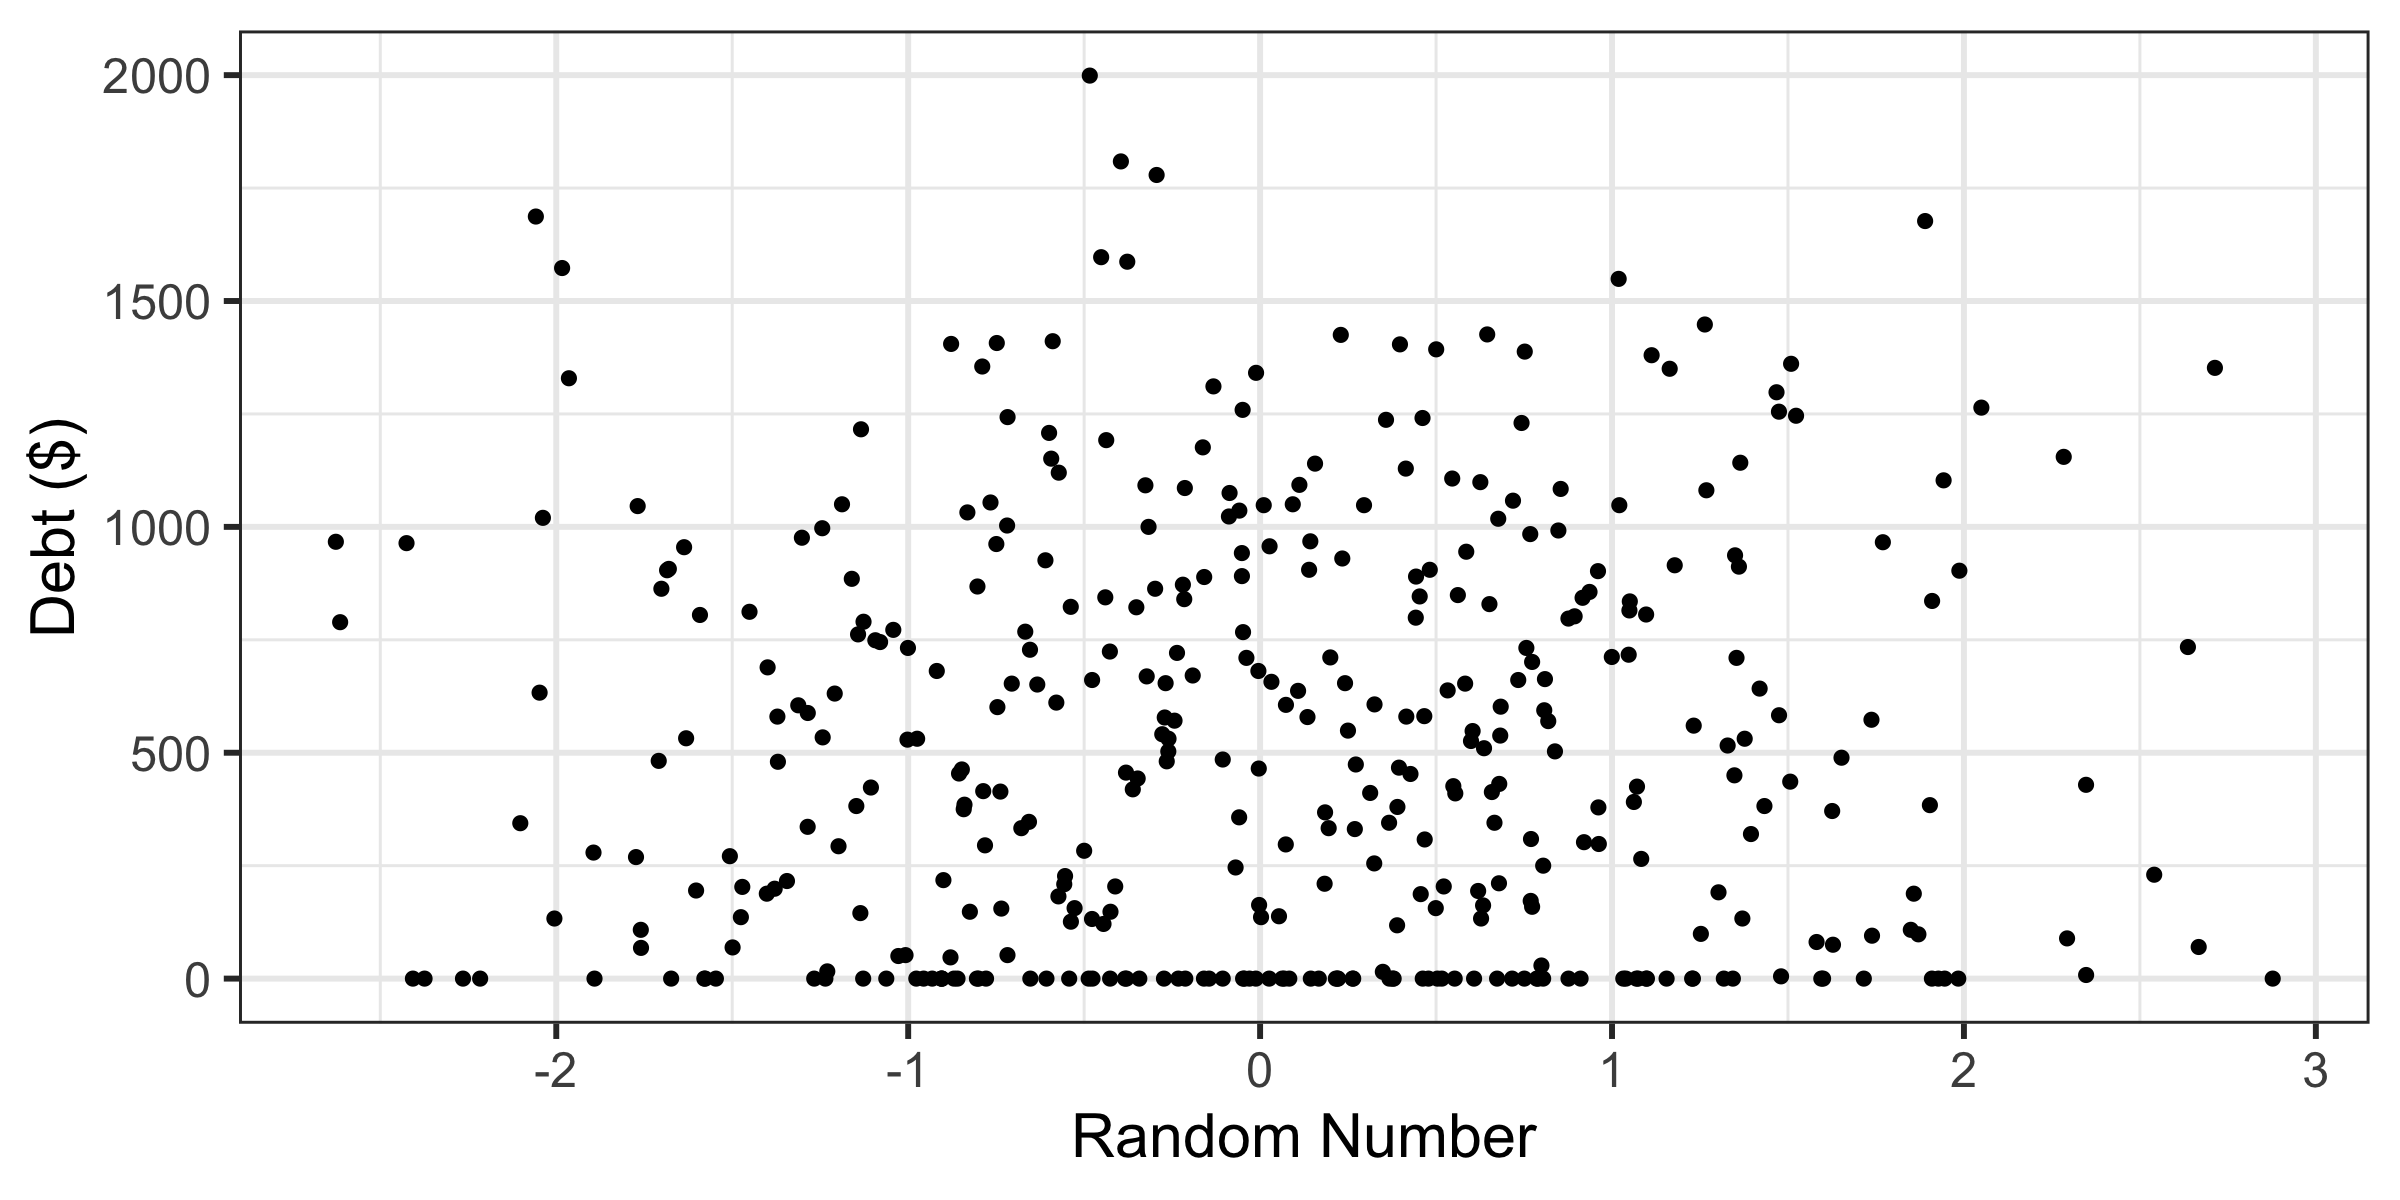

In [124]:
# Visualize the random variable

data_random <- data |>
  add_column(random = rnorm(length(data$limit), mean = 0, sd = 1))

plot3 <- ggplot(data_random, aes(y = debt, x = random)) +
  geom_point(size = 0.7) +
  theme_classic() +
  theme +
  labs(x = "Random Number", y = "Debt ($)")

print(cor(data_random$random, data_random$debt))
plot3

**Let's check:**

In [125]:
model2b <- lm(debt ~ limit + rating + random, data_random)
regression_table(model2b)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-378.371,-8.332
limit,0.023,0.364
rating,2.220,2.323
random,2.961,0.274


In [127]:
# Recall:

model2 <- lm(debt ~ limit + rating, data)
regression_table(model2)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-377.537,-8.343
limit,0.025,0.384
rating,2.202,2.312


### Summary so far...

- Credit `limit` and credit `rating` are almost perfectly correlated (collinear), $R=1$

- Using `limit` + `income` doesn't really help explain much more of the variance in `debt`

    A) $\hat{debt} = \beta_0 + \beta_1\textrm{limit}$ ; $R^2 = 0.74$
    
    B) $\hat{debt} = \beta_0 + \beta_1\textrm{limit} + \beta_2\textrm{income}$ ; $R^2 = 0.75$
    
- Let's explore this a bit more to identify one more issue with collinearity

## Introduction to Collinearity (10 mins)

In today's class we will discuss the problem of multicolinearity in linear regression.

### What if two explanatory variables in our linear model were correlated?

1. Consider the cofficients $\beta_1$ and $\beta_2$ for credit `limit` and credit `rating` in a regression model. 
    - How would $\beta_1$ and $\beta_2$ be affected if `limit` and `rating` were correlated?

2. How would we check to see if two variables were correlated?
    - Hint: You already know how to do this!

3. **Make a prediction**: should we be concerned if our explanatory variables were correlated?
    - Hint: does it depend on what we hope to achieve with the regression?

#### Check if credit `limit` is correlated with `income`

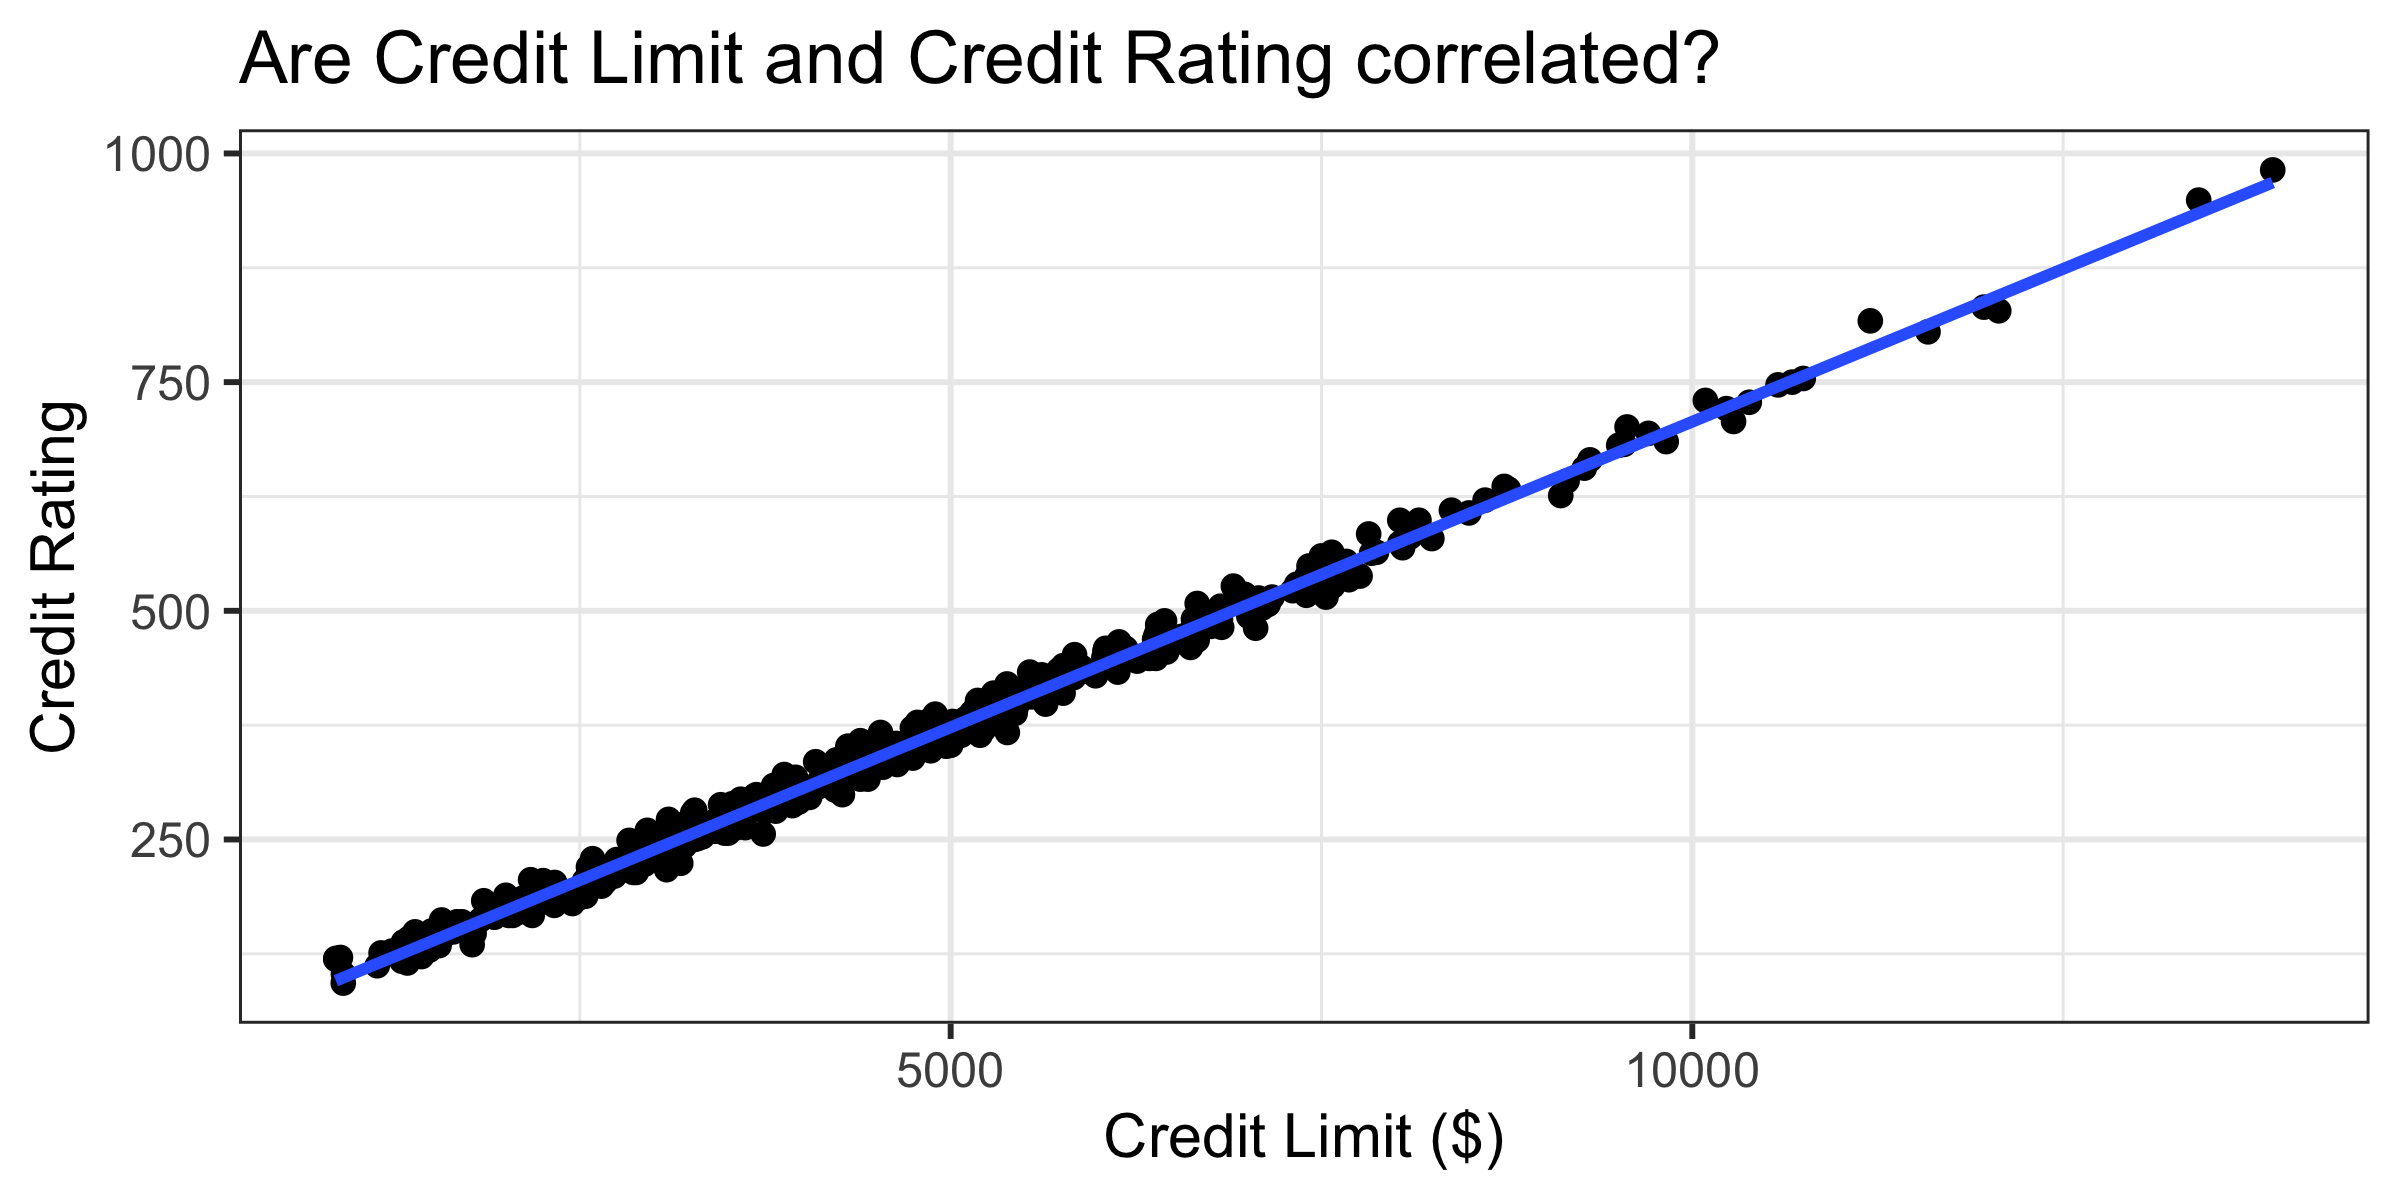

In [10]:
plot4 <- ggplot(data, aes(y = rating, x = limit)) +
  geom_point() +
  theme_classic() +
  theme +
  labs(x = "Credit Limit ($)", y = "Credit Rating", title = "Are Credit Limit and Credit Rating correlated?") +
  geom_smooth(method = "lm", se = FALSE, formula = y ~ x)

plot4

### Key Point

- Linear Regression is just a tool in your toolkit
- The `response` variables and `explanatory` variables can be different depending on your **research question** is
- There's nothing magical about it...

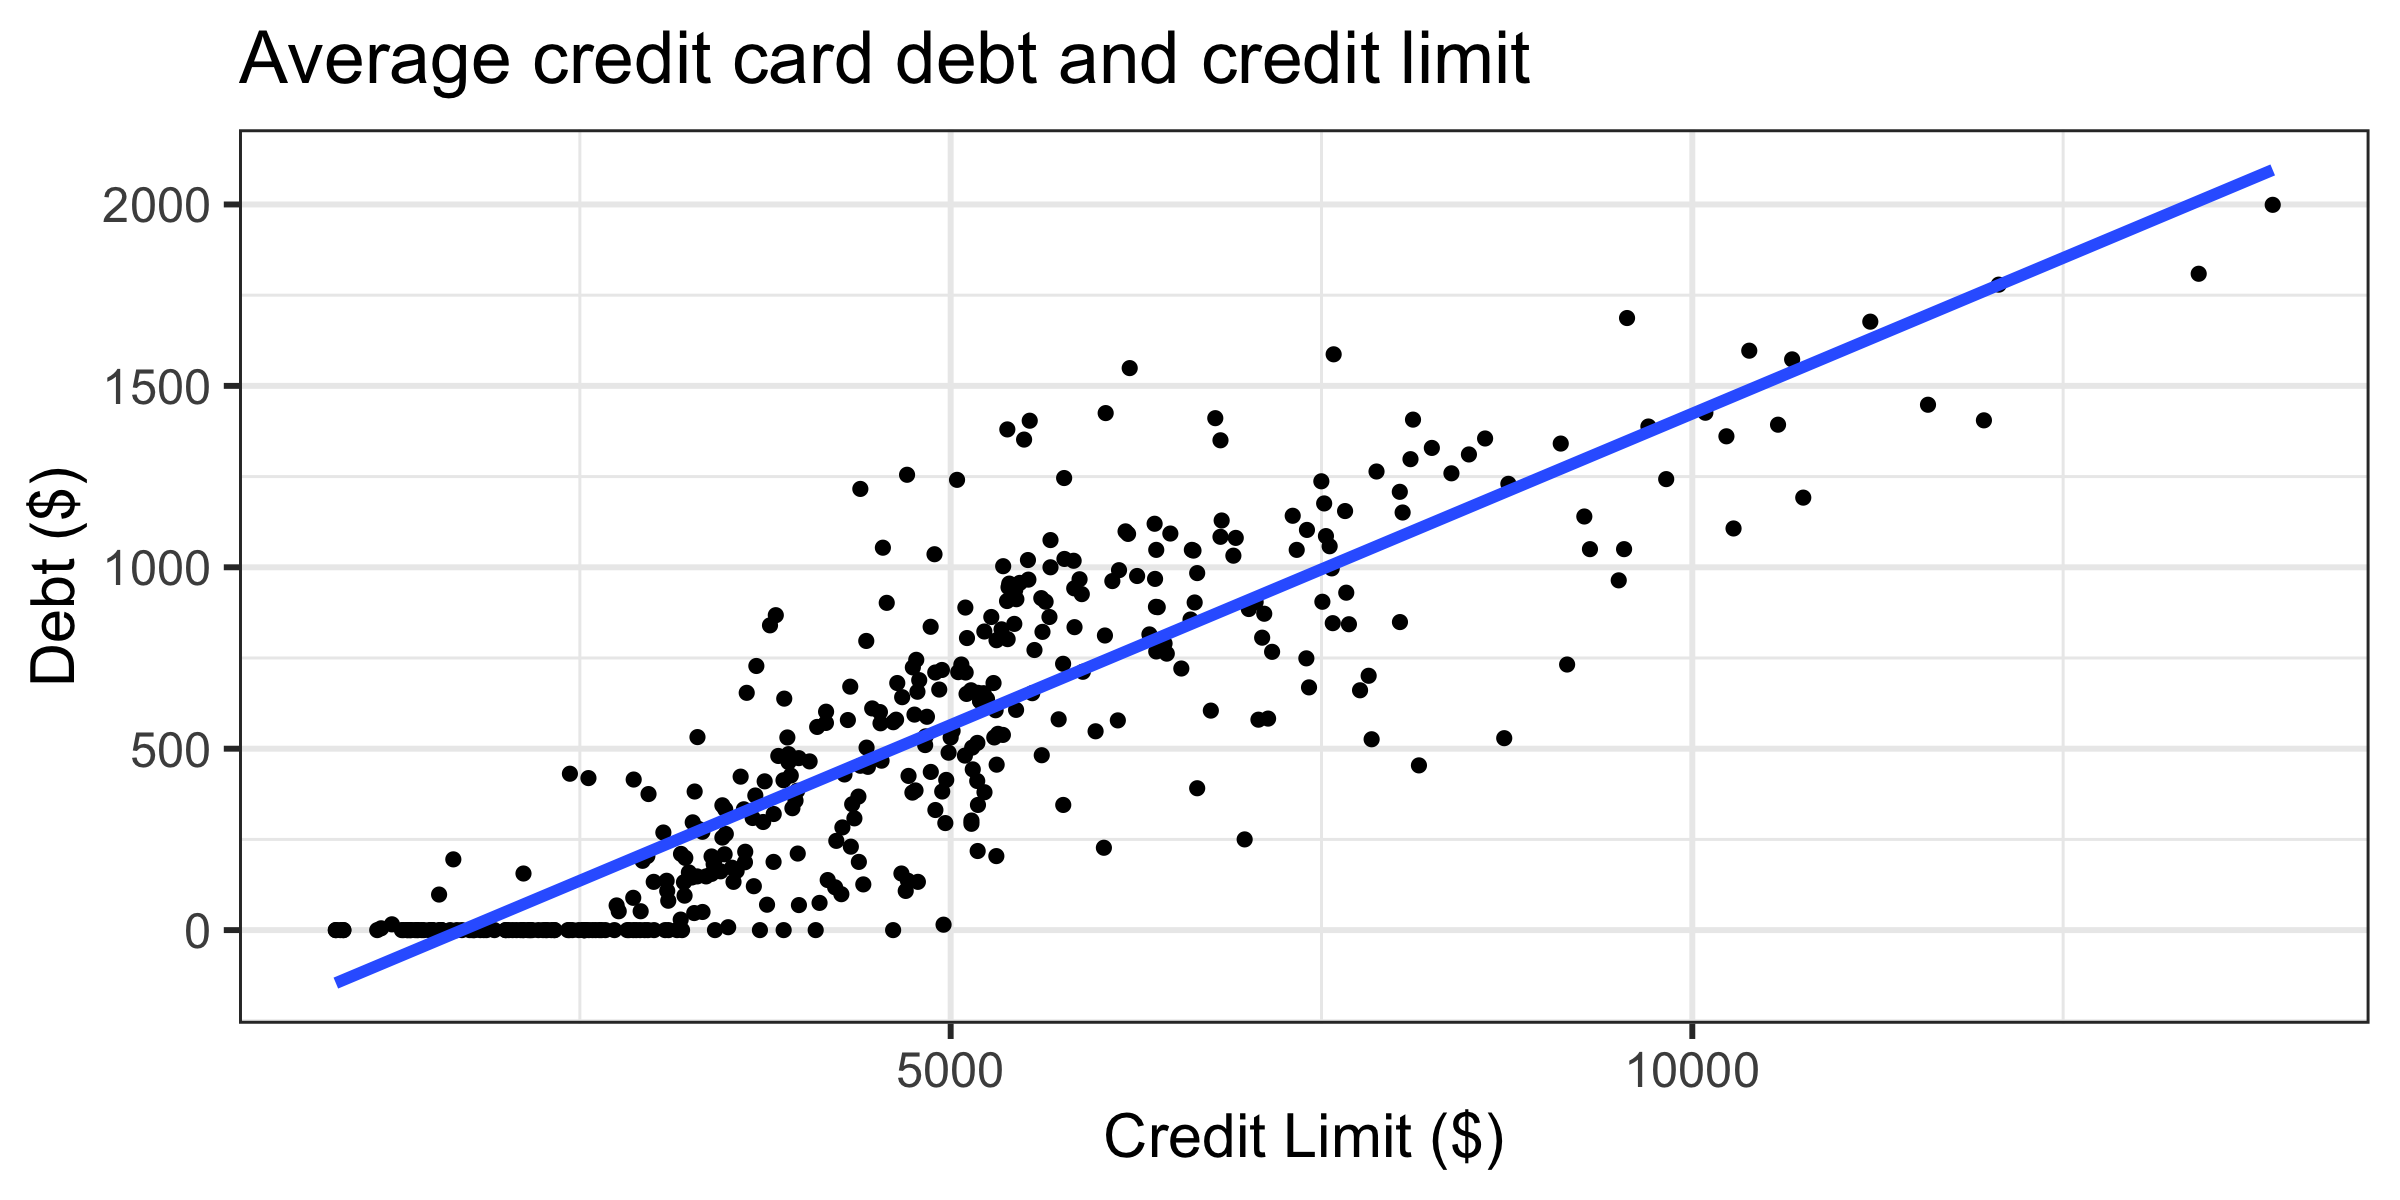

In [11]:
plot1 + geom_smooth(method = "lm", se = FALSE, formula = y ~ x) + labs(title = "Average credit card debt and credit limit")

In [12]:
model3 <- lm(rating ~ limit, data)
fit_summary(model3)

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
1,0.99,400,63478.33


##### Interpretation

$R = 1 $ ; Strength of the linear relationship between two variables.

$R^2 = 0.99 $ ; The proportion of the variance in the response variable that can be explained by the explanatory variables in the regression model.

### Summary so far...

- Credit `limit` and credit `rating` are almost perfectly correlated (collinear), $R=1$

- Using `limit` + `income` doesn't really help explain much more of the variance in `debt`

    A) $\hat{debt} = \beta_0 + \beta_1\textrm{limit}$ ; $R^2 = 0.74$
    
    B) $\hat{debt} = \beta_0 + \beta_1\textrm{limit} + \beta_2\textrm{income}$ ; $R^2 = 0.75$
    
- Let's explore this a bit more to identify one more issue with collinearity

In [13]:
# Add a column of random numbers to the `data`

data_random <- data |>
  add_column(random = rnorm(length(data$limit), mean = 5, sd = 20))

In [14]:
model4 <- lm(debt ~ limit + rating + random, data_random)
regression_table(model4)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-387.203,-8.489
limit,0.023,0.365
rating,2.231,2.346
random,0.911,1.536


In [15]:
model5 <- lm(debt ~ limit + random, data_random)
regression_table(model5)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-301.071,-11.059
limit,0.172,33.928
random,0.883,1.481


In [19]:
for (k in 1:15) {
  data_random <- data |>
    add_column(random = rnorm(length(data$limit), mean = 0, sd = 1))

  l1 <- regression_table(lm(debt ~ limit + rating + random, data_random))[[2, 2]]
  l2 <- regression_table(lm(debt ~ limit + random, data_random))[[2, 2]]
  print(c(l1, l2))
}

[1] 0.025 0.171
[1] 0.024 0.172
[1] 0.023 0.172
[1] 0.030 0.171
[1] 0.024 0.172
[1] 0.024 0.172
[1] 0.025 0.171
[1] 0.024 0.172
[1] 0.023 0.172
[1] 0.026 0.172
[1] 0.023 0.173
[1] 0.018 0.171
[1] 0.023 0.172
[1] 0.017 0.171
[1] 0.021 0.171


### Key Point

Revisiting: What if two explanatory variables in our linear model were correlated?

1. Consider the cofficients $\beta_1$ and $\beta_2$ for credit `limit` and credit `rating` in a regression model. 
    - How would $\beta_1$ and $\beta_2$ be affected if `limit` and `rating` were correlated?
    - **A: Standard error of $\beta_1$ and $\beta_2$ will increase, and small changes to the model will cause wild oscillations between larger upper and lower bounds.**

2. How would we check to see if two variables were correlated? 
    - Hint: You already know how to do this!
    - **A: Just run another linear regression!**

3. **Make a prediction**: should we be concerned if our explanatory variables were correlated?
    - Hint: does it depend on what we hope to achieve with the regression?
    - **A: Yes! But only if we care about interpreting the $\beta$ coefficients (i.e. not using regression for prediction)**

#### Corellogram: A way to visualize bivariate (two variables) correlations

In [19]:
res <- cor(data |> select(where(is.numeric)))
round(res, 2)

,id,income,limit,rating,cards,age,education,debt
id,1.00,0.04,0.02,0.02,-0.04,0.06,0.00,0.01
income,0.04,1.00,0.79,0.79,-0.02,0.18,-0.03,0.46
limit,0.02,0.79,1.00,1.00,0.01,0.10,-0.02,0.86
rating,0.02,0.79,1.00,1.00,0.05,0.10,-0.03,0.86
cards,-0.04,-0.02,0.01,0.05,1.00,0.04,-0.05,0.09
age,0.06,0.18,0.10,0.10,0.04,1.00,0.00,0.00
education,0.00,-0.03,-0.02,-0.03,-0.05,0.00,1.00,-0.01
debt,0.01,0.46,0.86,0.86,0.09,0.00,-0.01,1.00


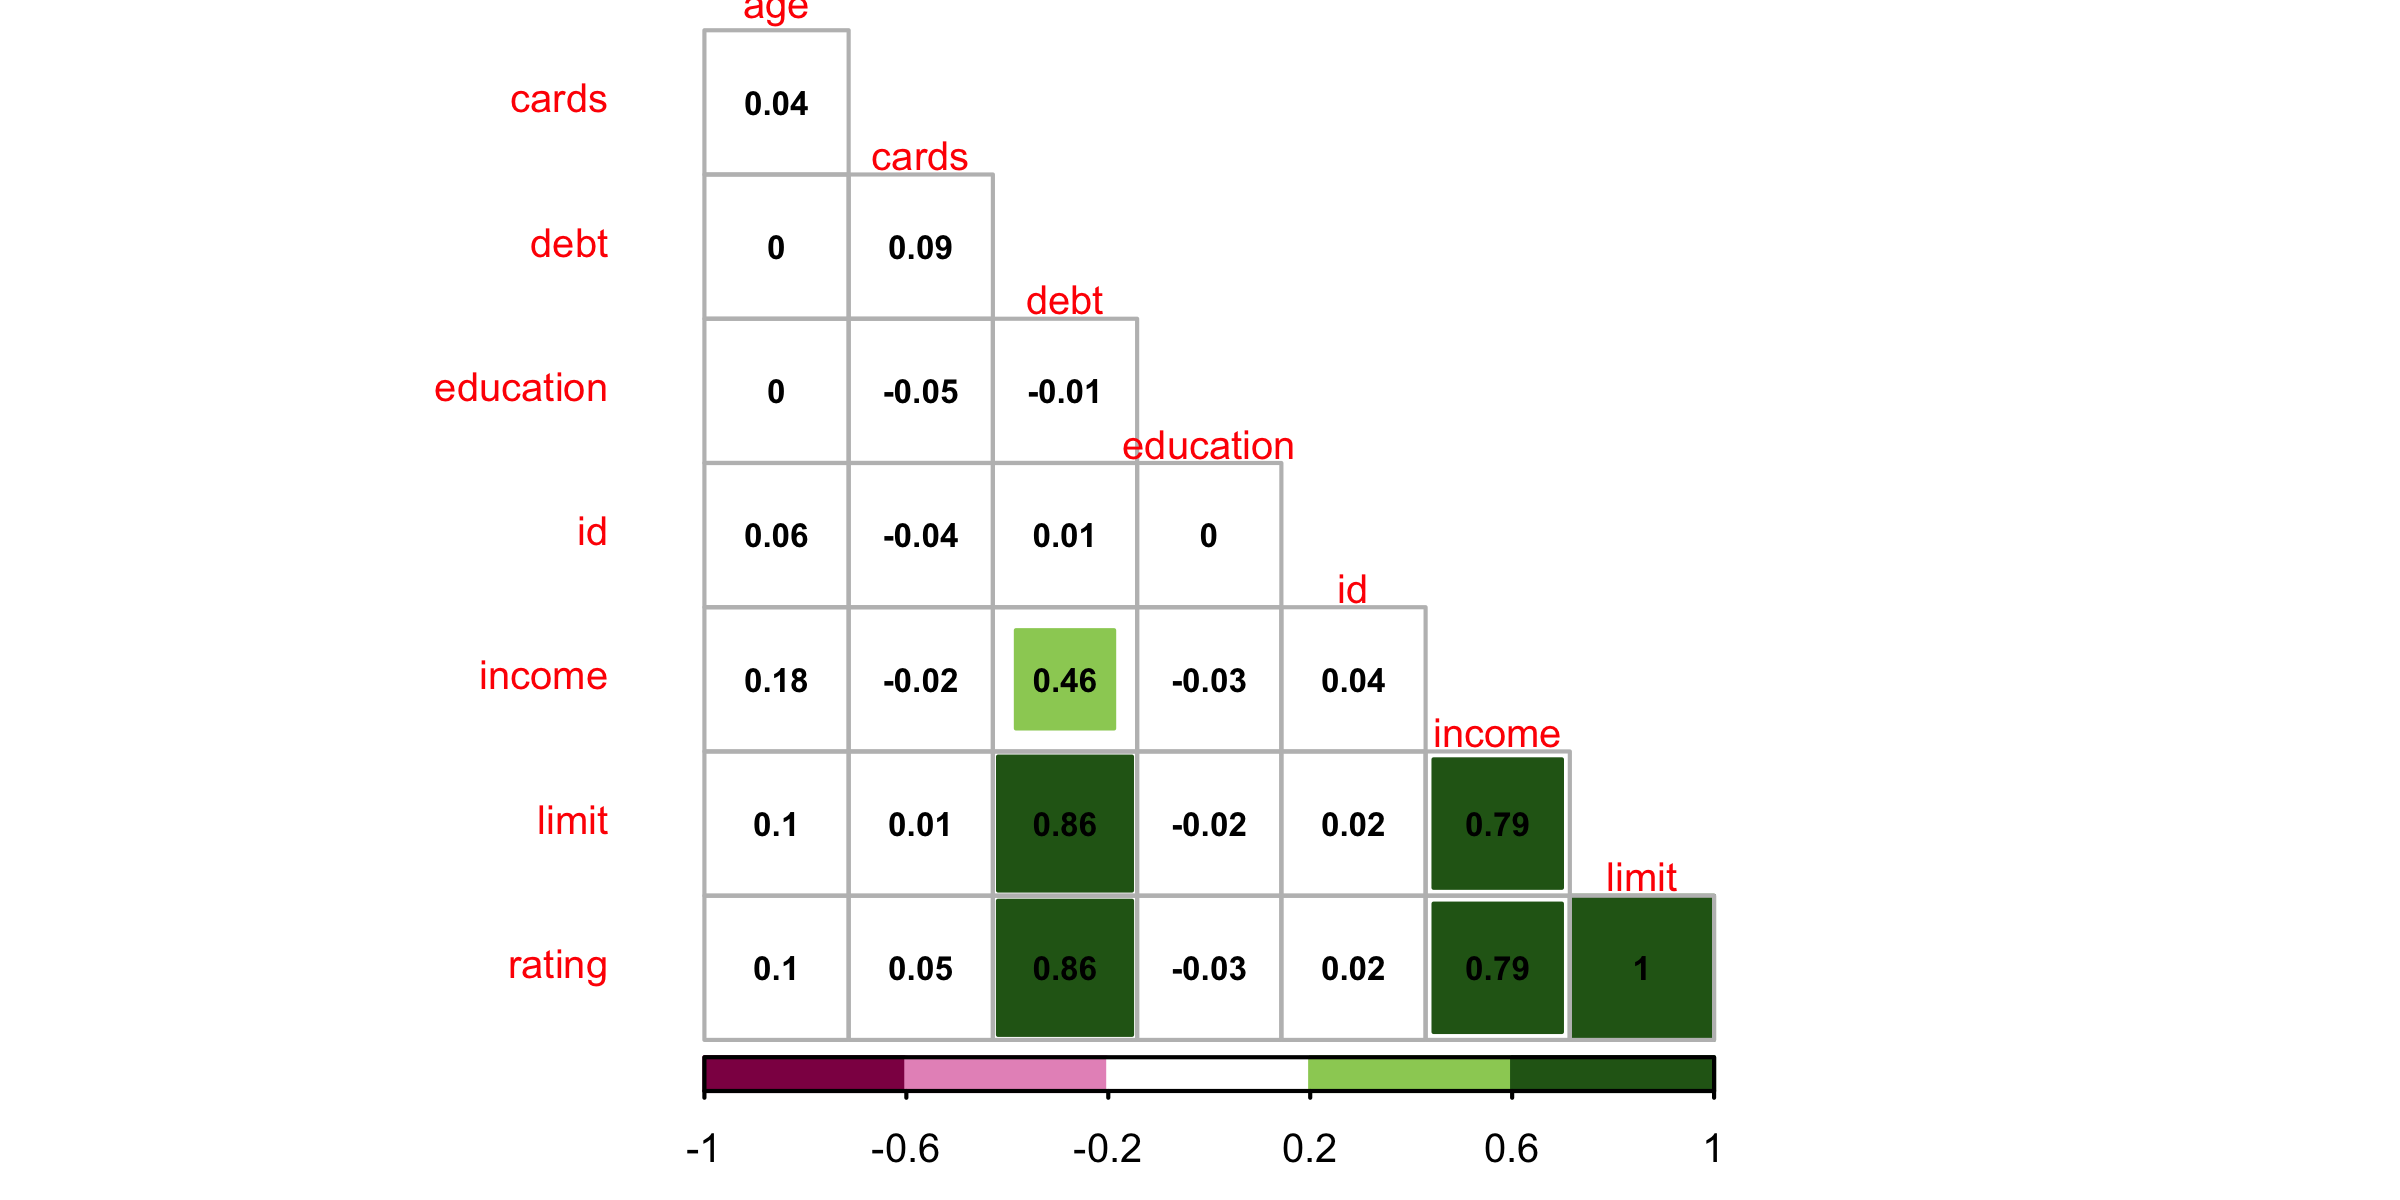

In [20]:
corrplot(res,
  method = "square", type = "lower", diag = FALSE,
  addCoef.col = "black", number.cex = 0.5, cl.cex = 0.6, tl.cex = 0.6, tl.pos = "ld", tl.offset = 1.2,
  order = "alphabet", tl.srt = 0, col = COL2("PiYG", 5)
)

## What about multivariate collinearity? (8 mins)

- Unfortunately, it is also possible for collinearity to exist between three or more variables even if no single pair of variables has a particularly high correlation.

- So how can we tell if more than two variables are collinear (multicollinearity)?

- Let's formulate the question a bit more formally:
    - "Given $n$ explanatory variables $X_1, X_2, X_3, ...,X_i,... X_n$, how much of the variance in $X_i$ is explained by all other explanatory variables?"

- This sounds like we need to do another regression, and our question can be answered by computing $R^2_i$.

### Step 1: Compute $R^2_i$ 

For the explanatory variables: `limit`, `rating`, `income`, `age`:

$X_1$ = `limit`
$X_2$ = `rating`
$X_3$ = `income`
$X_4$ = `age`

The corresponding $R^2_i$s can be found by doing four separate regression analyses, and then computing $R^2$ as usual:

1. $lm$($X_1$ ~ $X_2$ + $X_3$ + $X_4$) $\rightarrow$ $R^2_1$

2. $lm$($X_2$ ~ $X_1$ + $X_3$ + $X_4$) $\rightarrow$ $R^2_2$

3. $lm$($X_3$ ~ $X_1$ + $X_2$ + $X_4$) $\rightarrow$ $R^2_3$

4. $lm$($X_4$ ~ $X_1$ + $X_2$ + $X_3$) $\rightarrow$ $R^2_4$

### Step 2: Compute the Variance Inflation Factor (VIF)

- The severity of multicollinearity can be determined for each explanatory variable, by transforming $R^2_i$ to the Variance Inflation Factor, or VIF:

\begin{equation}
\textrm{VIF}_i = \frac{1}{1-R^2_i}\textrm{, where } 0 \leq R^2_i \leq 1
\end{equation}


| Variance Inflation Factor | Value           |
| --- | --------------- |
| $\textrm{VIF}_{limit}$ | 100 |
| $\textrm{VIF}_{rating}$ | 100 |
| $\textrm{VIF}_{income}$ | 2.78 |
| $\textrm{VIF}_{age}$ | 1.04  |


In [21]:
# You Try!
## Write a function to calculate VIF if provided an R^2 value

vif <- function(R2) {
  return(round(1 / (1 - R2), 2))
}

vif(fit_summary(lm(rating ~ limit + income + age, data))[[1, 2]])

# Calculate VIF in one step
# round(1 / (1 - fit_summary(lm(rating ~ limit + income + age, data))[[1, 2]]), 2)
# car::vif(lm(debt ~ limit + age + cards, data)) //Alternate way using `car` package

[1] 100

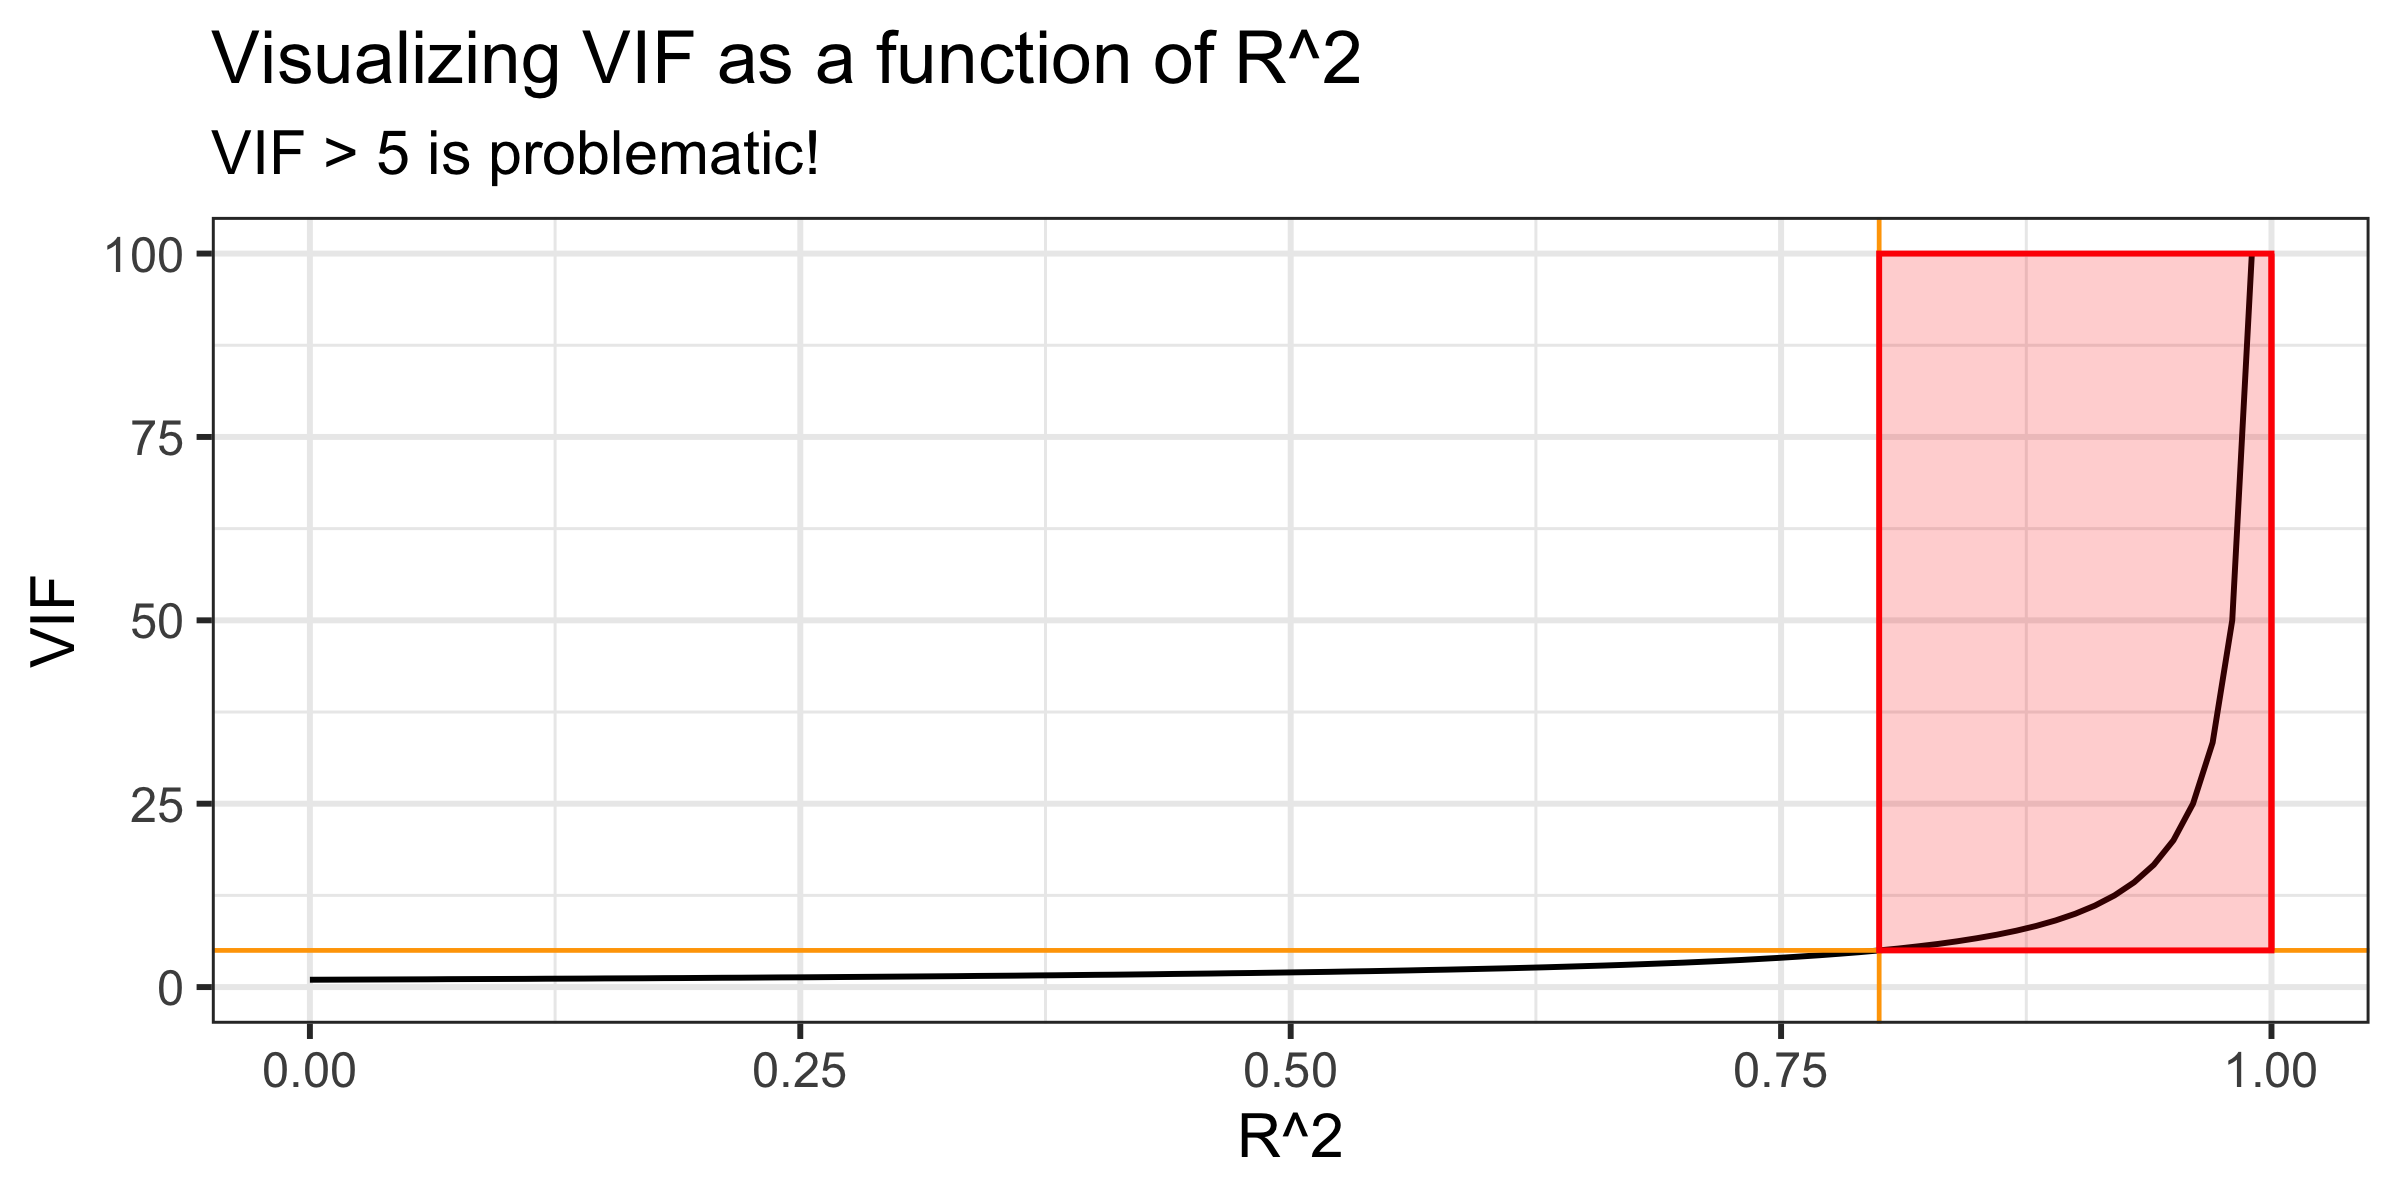

In [379]:
vif_data <- tibble(y = vif(seq(0, 99) / 100), x = seq(0, 99) / 100)

ggplot(vif_data, aes(x = x, y = y)) +
  geom_line() +
  labs(x = "R^2", y = "VIF", title = "Visualizing VIF as a function of R^2", subtitle = "VIF > 5 is problematic!") +
  theme +
  geom_hline(yintercept = 5, color = "orange", size = 0.4) +
  geom_vline(xintercept = 0.8, color = "orange", size = 0.4) +
  annotate("rect", xmin = c(0.8, 1), xmax = c(1, 1), ymin = c(5, 5), ymax = c(100, 100), alpha = 0.2, color = "red", fill = "red") +
  ylim(0, 100)

### Summary so far...

- The correlation $R$ is useful when determining whether two variables are collinear.

- To diagnose multi-collinearity, the Variance Inflation Factor (VIF) is a useful quantity to calculate:

\begin{equation}
\textrm{VIF}_i = \frac{1}{1-R^2_i}\textrm{, where } 0 \leq R^2_i \leq 1
\end{equation}

- VIF values larger than ~ 5 ($R^2 > 0.8$) will result in some problems with the linear regression.

- But once we have identified multicollinearity, what are some strategies to address it?

## Addressing multicollinearity (2 mins)

There are three main ways to deal with multicollinearity:

1. Simply drop one of the multicollinear variables from your regression model.

2. Combine/Transform the collinear variables into a new composite variable.

3. Ignore the multicollinearity.
    - Only useful if you do NOT want to interpret the $\beta$ coefficients.

## Introducing Lab Question (3 mins)

In the lab questions, you will explore the three ways of addressing multicollinearity and reflect on some of the intuition you've developed with linear regression.

## Recap of Learning Intentions

- LI 1

- LI 2

- LI 3

- LI4